Running Multivariate Markov Switching on 202 months...
                        Markov Switching Model Results                        
Dep. Variable:                Oil_Ret   No. Observations:                  202
Model:               MarkovRegression   Log Likelihood                -683.080
Date:                Mon, 09 Feb 2026   AIC                           1386.161
Time:                        15:31:53   BIC                           1419.243
Sample:                    02-28-2006   HQIC                          1399.546
                         - 11-30-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5937      0.538      2.964      0.003       0.540       2.6

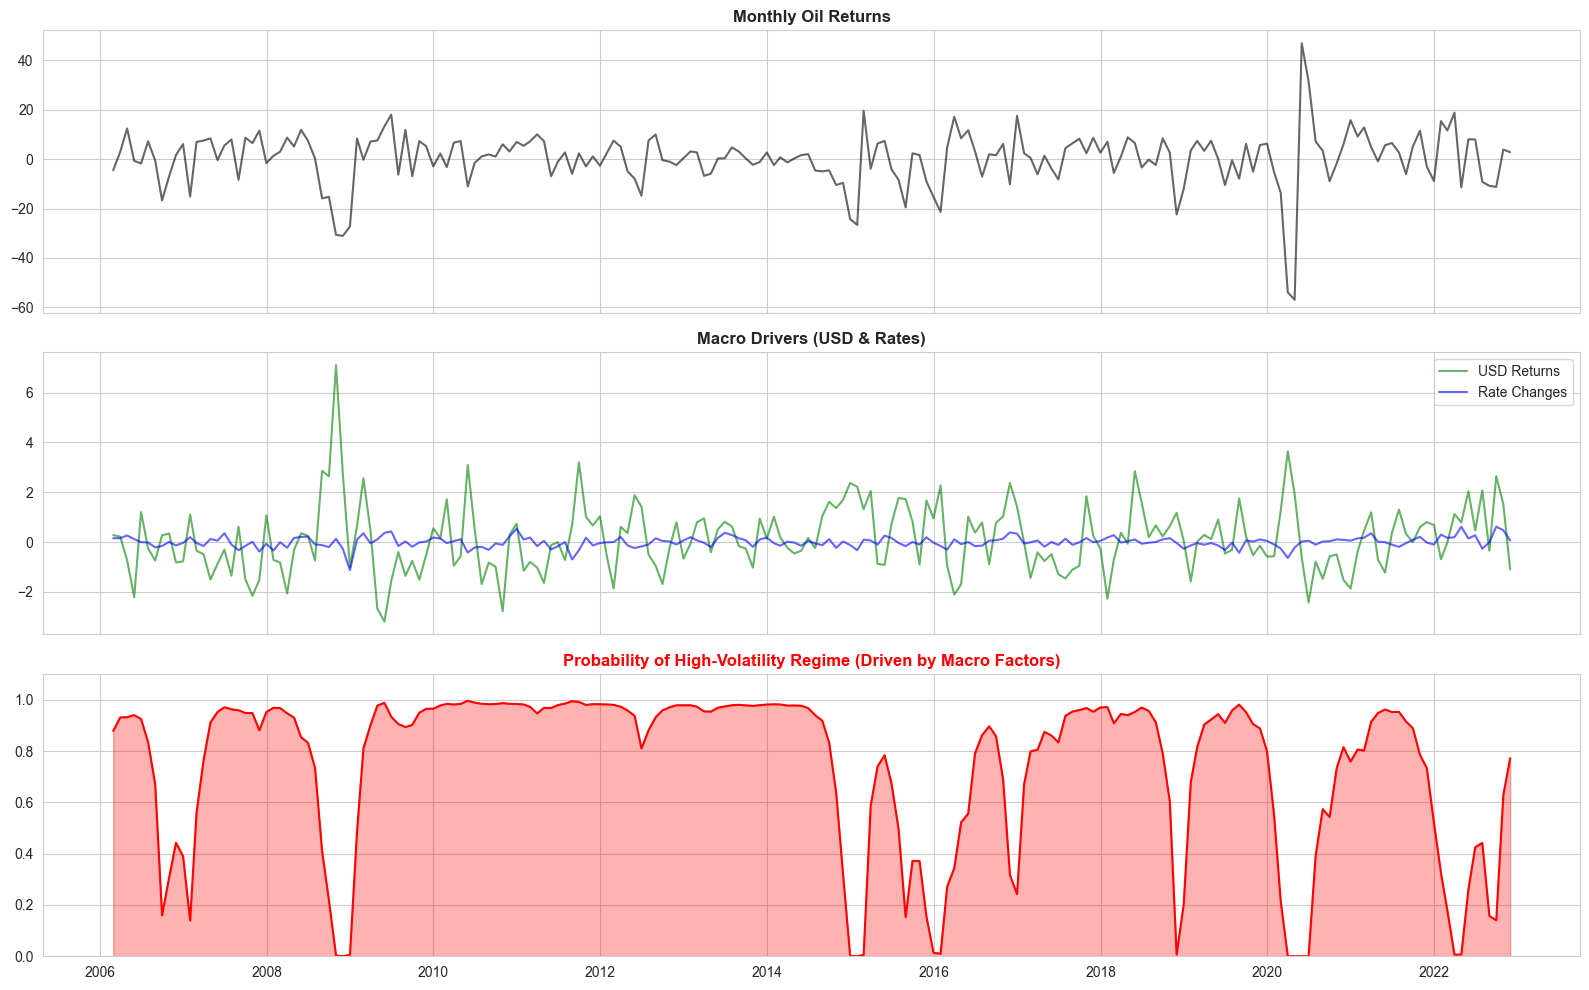


--- Impact of Macro Factors in Each Regime ---
p[0->0]        0.923543
p[1->0]        0.224168
const[0]       1.593746
const[1]       0.874431
x1[0]         -2.318287
x1[1]         -6.815788
x2[0]         12.805700
x2[1]         31.343385
sigma2[0]     25.452151
sigma2[1]    152.902555
dtype: float64


In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Setup
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (16, 10)

# 1. Load Your NEW Enriched Data
DATA_PATH = '../data/processed/brent_oil_enriched.csv'
df = pd.read_csv(DATA_PATH, index_col='Date', parse_dates=True)

# 2. Prep Data (Monthly Frequency is best for Macro Variables)
# We use monthly averages because GDP/CPI don't change daily
df_monthly = df.resample('ME').mean()

# Create Returns & Differences
df_monthly['Oil_Ret'] = np.log(df_monthly['Price']).diff() * 100
df_monthly['USD_Ret'] = np.log(df_monthly['USD_Index']).diff() * 100
df_monthly['Rate_Diff'] = df_monthly['Interest_Rate'].diff()

# Drop NaN from differencing
data = df_monthly.dropna()

print(f"Running Multivariate Markov Switching on {len(data)} months...")

# 3. Fit the Model with EXOGENOUS Variables
# dependent variable: Oil Returns
# exog (explanatory) variables: USD Returns + Interest Rate Changes
# switching_variance=True: Volatility can change (Calm vs Crisis)

# We are asking: "Do USD and Rates explain the mean return of Oil in different regimes?"
mod_macro = sm.tsa.MarkovRegression(
    endog=data['Oil_Ret'],
    k_regimes=2,                # Let's keep it simple: "Normal" vs "Shock"
    trend='c',                  # Constant trend
    exog=data[['USD_Ret', 'Rate_Diff']], # <--- THIS IS THE NEW PART
    switching_variance=True
)

res_macro = mod_macro.fit()
print(res_macro.summary())

# 4. Visualize: Did Macro Factors Predict the Crisis?
fig, axes = plt.subplots(3, 1, sharex=True)

# Plot 1: Oil Returns (The Target)
axes[0].plot(data.index, data['Oil_Ret'], color='black', alpha=0.6)
axes[0].set_title('Monthly Oil Returns', fontsize=12, fontweight='bold')

# Plot 2: The Macro Drivers (USD & Rates)
axes[1].plot(data.index, data['USD_Ret'], color='green', alpha=0.6, label='USD Returns')
axes[1].plot(data.index, data['Rate_Diff'], color='blue', alpha=0.6, label='Rate Changes')
axes[1].set_title('Macro Drivers (USD & Rates)', fontsize=12, fontweight='bold')
axes[1].legend()

# Plot 3: Probability of "Crisis Regime" (High Volatility)
# Usually regime 0 is low vol, regime 1 is high vol, but check the summary to be sure
crisis_prob = res_macro.smoothed_marginal_probabilities[0] # or [1], check output
axes[2].plot(crisis_prob, color='red', fillstyle='full')
axes[2].fill_between(data.index, crisis_prob, color='red', alpha=0.3)
axes[2].set_title('Probability of High-Volatility Regime (Driven by Macro Factors)', fontsize=12, fontweight='bold', color='red')
axes[2].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# 5. Interpret the Impact
print("\n--- Impact of Macro Factors in Each Regime ---")
print(res_macro.params)